In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier, Pool

from sklearn.metrics import roc_auc_score

Kaggle Diabetes Prediction Competition:

This dataset contains patient records designed for diabetes risk prediction, with features based on demographics, lifestyle habits, family history, and clinical measurements that are well-established indicators of diabetes risk. All data is generated using statistical distributions inspired by real-world medical research.

In [ ]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

In [45]:
df_train.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [46]:
print(df_train.shape, df_test.shape)

(700000, 26) (300000, 25)


#### 1. EDA and feature engineering

This notebook performs **model-based EDA** using a **baseline CatBoost classifier** as the first reference model.  
After training the baseline model, we compute **SHAP values** to interpret predictions and quantify feature contributions.

CatBoost is chosen as the baseline because it typically performs strongly on tabular data, and handles categorical variables robustly with minimal preprocessing. This makes it a reliable model for extracting meaningful patterns early in the workflow.

We will use SHAP as it could explain model outputs by attributing each prediction to individual features. Compared to basic correlation-based EDA, SHAP can help to uncover non-linear trends and interaction effects between the features. Specifically, we will generate:
- **SHAP feature importance** to identify the most influential predictors
- **SHAP dependence plots** to visualize non-linear effects and feature interactions

These insights will guide downstream feature engineering decisions (e.g., transformations, binning, interaction features, or removal of redundant variables).

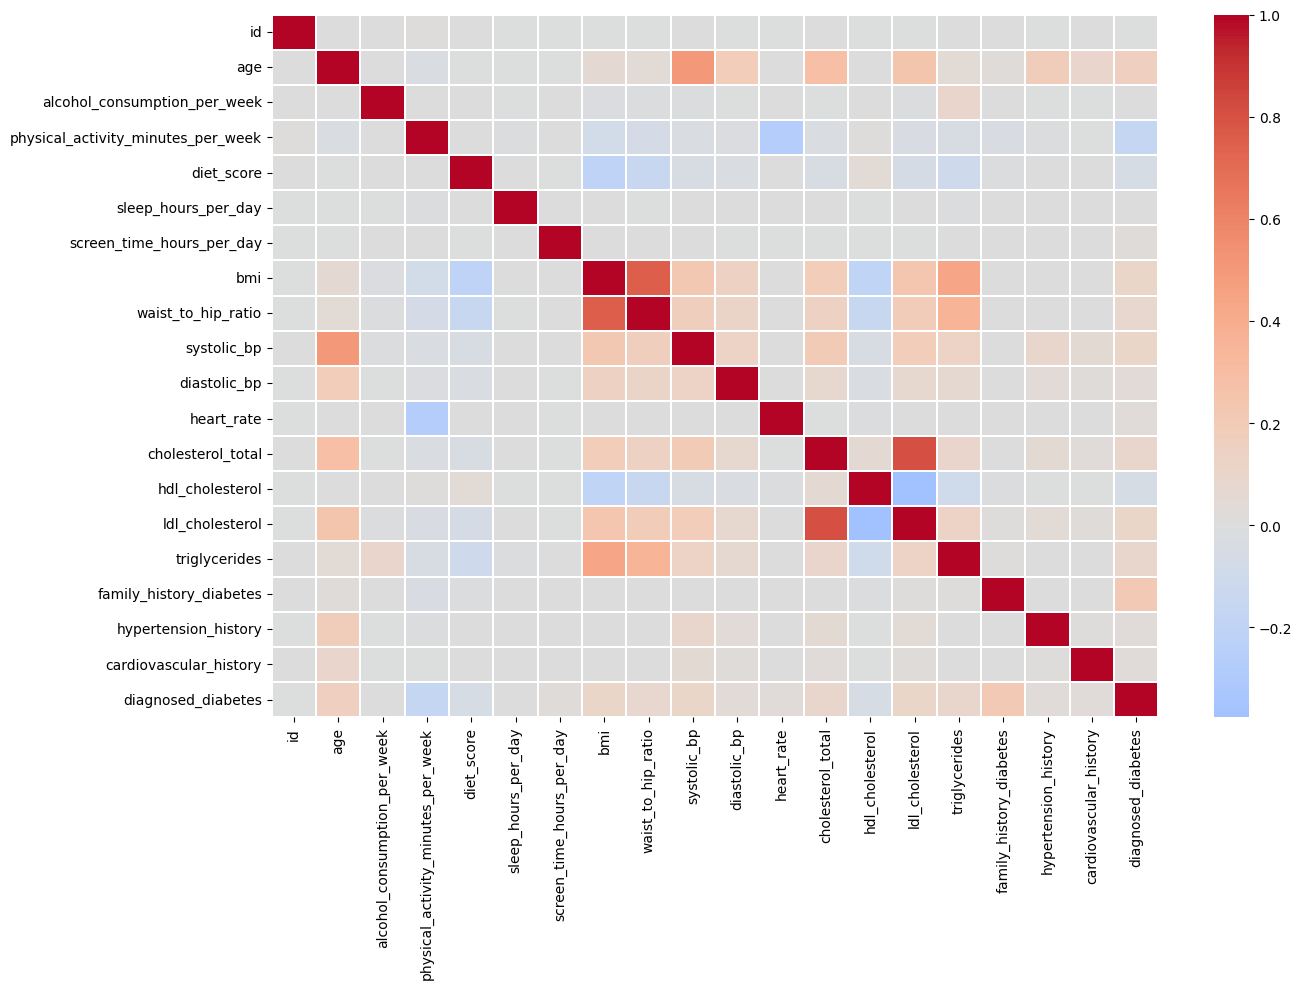

In [47]:
# Correlation matrix

# Keep numeric columns only
numeric_cols = df_train.select_dtypes(include=["int64", "float64"]).columns

# Compute correlation matrix
corr_matrix = df_train[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=False,
    linewidths=0.3
)

plt.tight_layout()
plt.show()

In [48]:
df_train["diagnosed_diabetes"].value_counts(normalize=True)
# 60% positive, 40% negative

,proportion
diagnosed_diabetes,
1.0,0.623296
0.0,0.376704


In [49]:
df_train.columns.tolist()

['id',
 'age',
 'alcohol_consumption_per_week',
 'physical_activity_minutes_per_week',
 'diet_score',
 'sleep_hours_per_day',
 'screen_time_hours_per_day',
 'bmi',
 'waist_to_hip_ratio',
 'systolic_bp',
 'diastolic_bp',
 'heart_rate',
 'cholesterol_total',
 'hdl_cholesterol',
 'ldl_cholesterol',
 'triglycerides',
 'gender',
 'ethnicity',
 'education_level',
 'income_level',
 'smoking_status',
 'employment_status',
 'family_history_diabetes',
 'hypertension_history',
 'cardiovascular_history',
 'diagnosed_diabetes']

### Baseline model: CatBoost

In [50]:
# 1. Prepare data
drop_cols = ['id', 'diagnosed_diabetes']

X = df_train.drop(columns=drop_cols, errors='ignore')
y = df_train['diagnosed_diabetes']

X_test = df_test.drop(columns=drop_cols, errors='ignore')

cat_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
cat_features += ["family_history_diabetes", "hypertension_history", "cardiovascular_history"]

In [51]:
# 2. Catboost baseline
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=5)
cv_scores = []
params_catboost = {
      "iterations": 5000,
      "loss_function": "Logloss",
      "eval_metric": "Logloss",
      "random_seed": 5,
      "verbose": 500,
      "auto_class_weights": "Balanced",
      'depth': 8,
      'learning_rate': 0.05,
      "task_type": 'GPU',
      "devices": '0',
  }

for train_idx, val_idx in skf.split(X, y):
  X_train_fold = X.iloc[train_idx].copy()
  y_train_fold = y.iloc[train_idx].copy()
  X_val_fold = X.iloc[val_idx].copy()
  y_val_fold = y.iloc[val_idx].copy()

  train_pool = Pool(X_train_fold, y_train_fold, cat_features=cat_features)
  val_pool = Pool(X_val_fold, y_val_fold, cat_features=cat_features)

  model_catboost = CatBoostClassifier(**params_catboost)
  model_catboost.fit(train_pool, eval_set = val_pool, use_best_model=True, early_stopping_rounds=100)

  preds = model_catboost.predict_proba(val_pool)[:, 1]
  cv_scores.append(roc_auc_score(y_val_fold, preds))

print("CV AUC mean:", float(np.mean(cv_scores)), "std:", float(np.std(cv_scores)))

0:	learn: 0.6869803	test: 0.6869832	best: 0.6869832 (0)	total: 98.6ms	remaining: 8m 12s
500:	learn: 0.6037306	test: 0.6125733	best: 0.6125733 (500)	total: 36.7s	remaining: 5m 29s
1000:	learn: 0.5921296	test: 0.6112781	best: 0.6112725 (998)	total: 1m 13s	remaining: 4m 54s
bestTest = 0.6109751397
bestIteration = 1326
Shrink model to first 1327 iterations.
0:	learn: 0.6870108	test: 0.6870547	best: 0.6870547 (0)	total: 148ms	remaining: 12m 21s
500:	learn: 0.6042367	test: 0.6122753	best: 0.6122753 (500)	total: 36.4s	remaining: 5m 26s
1000:	learn: 0.5924225	test: 0.6104208	best: 0.6104173 (997)	total: 1m 12s	remaining: 4m 51s
1500:	learn: 0.5814375	test: 0.6100974	best: 0.6100886 (1466)	total: 1m 49s	remaining: 4m 15s
bestTest = 0.6100656834
bestIteration = 1537
Shrink model to first 1538 iterations.
0:	learn: 0.6869979	test: 0.6870104	best: 0.6870104 (0)	total: 104ms	remaining: 8m 41s
500:	learn: 0.6042129	test: 0.6119025	best: 0.6119025 (500)	total: 36.6s	remaining: 5m 28s
1000:	learn: 0.5

In [52]:
# 3. SHAP feature importance and correlation plots
full_pool = Pool(X, y, cat_features=cat_features)

SHAP_model = CatBoostClassifier(**params_catboost)
SHAP_model.fit(full_pool)

0:	learn: 0.6869579	total: 163ms	remaining: 13m 34s
500:	learn: 0.6063878	total: 49.6s	remaining: 7m 25s
1000:	learn: 0.5979180	total: 1m 39s	remaining: 6m 38s
1500:	learn: 0.5903702	total: 2m 30s	remaining: 5m 49s
2000:	learn: 0.5833979	total: 3m 20s	remaining: 5m
2500:	learn: 0.5763861	total: 4m 10s	remaining: 4m 10s
3000:	learn: 0.5697736	total: 5m 1s	remaining: 3m 21s
3500:	learn: 0.5632332	total: 5m 52s	remaining: 2m 30s
4000:	learn: 0.5568296	total: 6m 43s	remaining: 1m 40s
4500:	learn: 0.5506267	total: 7m 33s	remaining: 50.3s
4999:	learn: 0.5445386	total: 8m 24s	remaining: 0us


In [53]:
# SHAP plots

# Stratified sampling due to unbalanced classes
X_shap = (
    X.assign(__y=y)
    .groupby("__y", group_keys=False)
    .apply(lambda df: df.sample(2500, random_state=5))
    .drop(columns="__y")
)
y_shap = y.loc[X_shap.index]
shap_pool = Pool(X_shap, y_shap, cat_features=cat_features)

shap_values_full = SHAP_model.get_feature_importance(shap_pool, type="ShapValues")
shap_values = shap_values_full[:, :-1]

/tmp/ipython-input-3833784701.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sample(2500, random_state=5))


### 3. SHAP Plots

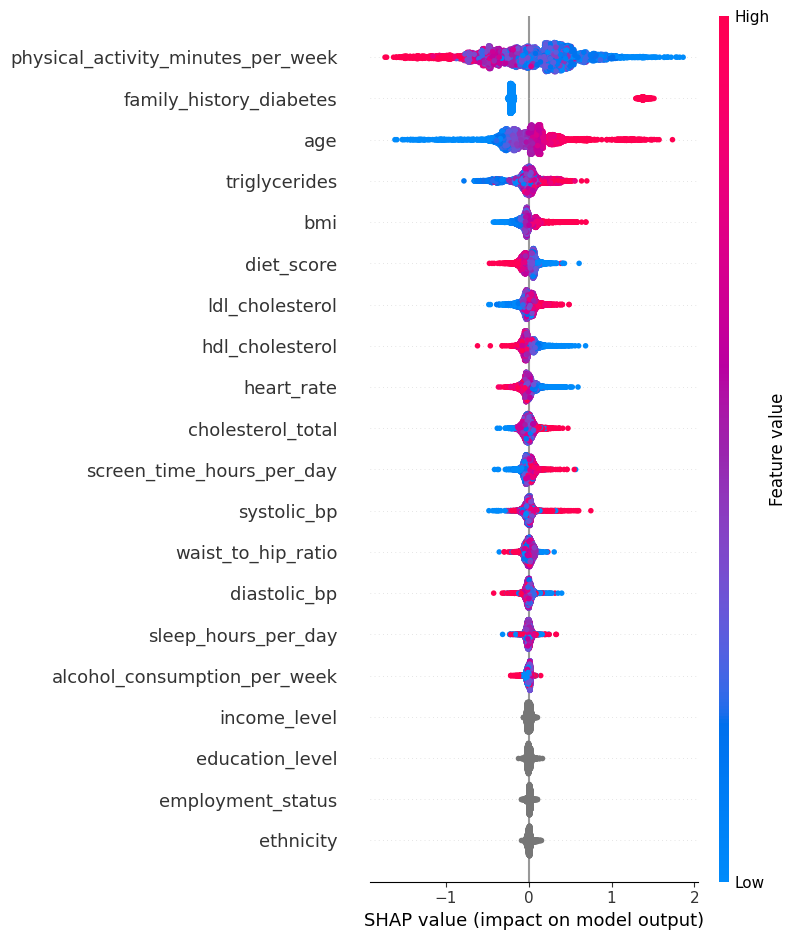

In [ ]:
# 1. Summary plot
shap.summary_plot(shap_values, X_shap)

# pick top features by mean(|SHAP|)
mean_abs = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(mean_abs)[::-1]
top_features = X_shap.columns[top_idx[:5]].tolist()

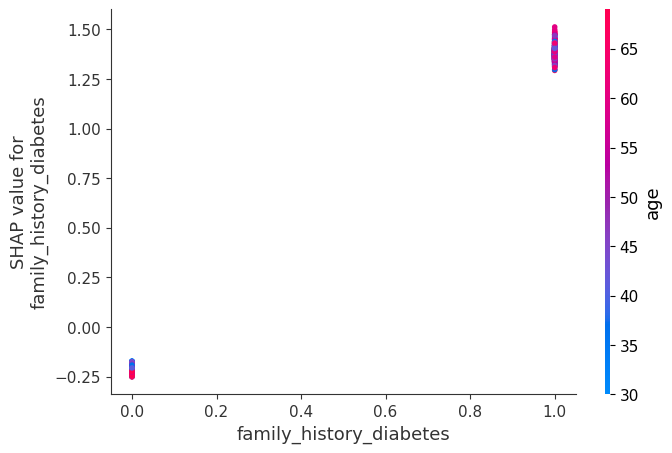

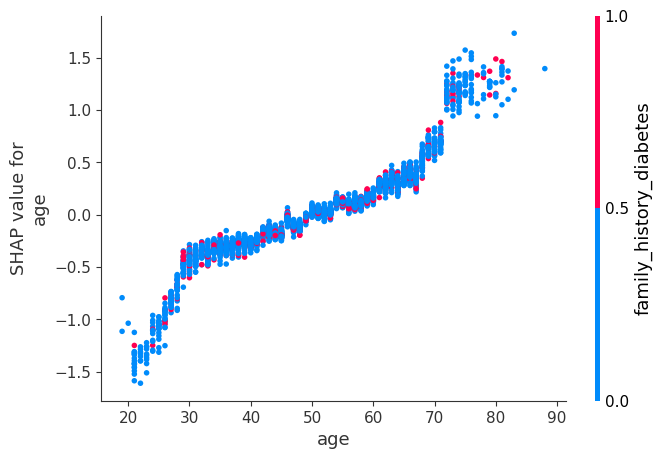

In [ ]:
# 2. Dependence plots between features
# Family history x age
shap.dependence_plot(
    "family_history_diabetes",
    shap_values,
    X_shap,
    interaction_index="age"
)

shap.dependence_plot(
    "age",
    shap_values,
    X_shap,
    interaction_index="family_history_diabetes"
)

# Risk increases monotonically with age, with a clear acceleration after ~60–70, where the SHAP contribution rises steeply.
# Non-linear trend, with younger ages (<30) associated with strongly negative SHAP values.

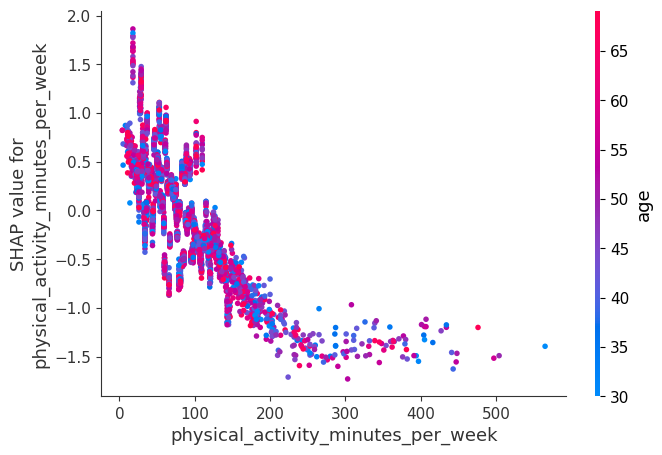

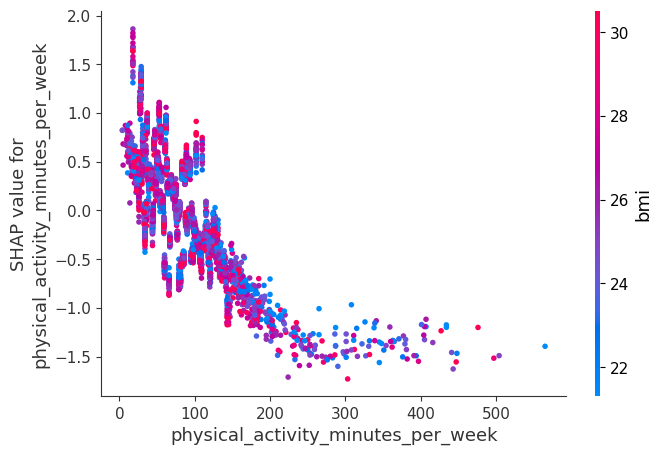

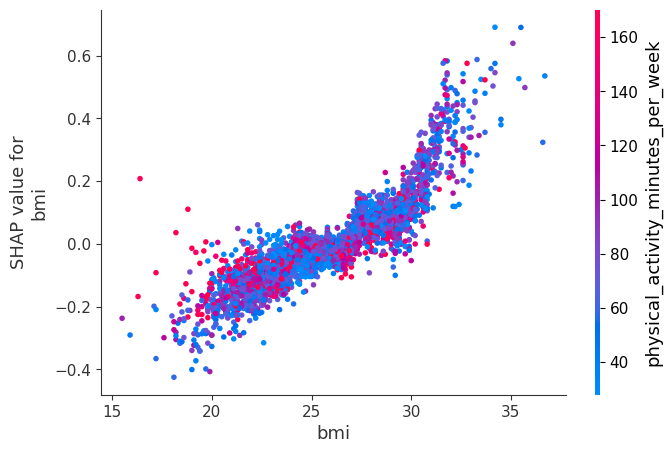

In [ ]:
shap.dependence_plot(
    "physical_activity_minutes_per_week",
    shap_values,    
    X_shap,
    interaction_index="age"
)

shap.dependence_plot(
    "physical_activity_minutes_per_week",
    shap_values,
    X_shap,
    interaction_index="bmi"
)

# (also useful the other way around)
shap.dependence_plot(
    "bmi",
    shap_values,
    X_shap,
    interaction_index="physical_activity_minutes_per_week"
)

# Plot 1:
# Higher physical activity is strongly protective, with SHAP values dropping sharply as activity increases up to around ~200 minutes/week.
# Beyond ~200–250 minutes/week, the marginal benefit plateaus, with SHAP values stabilizing near a lower bound.

# Plot 2:
# Similar to plot 1, with no distinct pattern for interaction with BMI

# Plot 3: 
# Risk rises gradually with BMI up to ~28–30, then increases much more steeply above ~30, showing a strong non-linear threshold effect.
# Suggests that obesity-range BMI contributes disproportionately to risk compared to moderate BMI increases, possibly add an obesity flag for high BMIs.

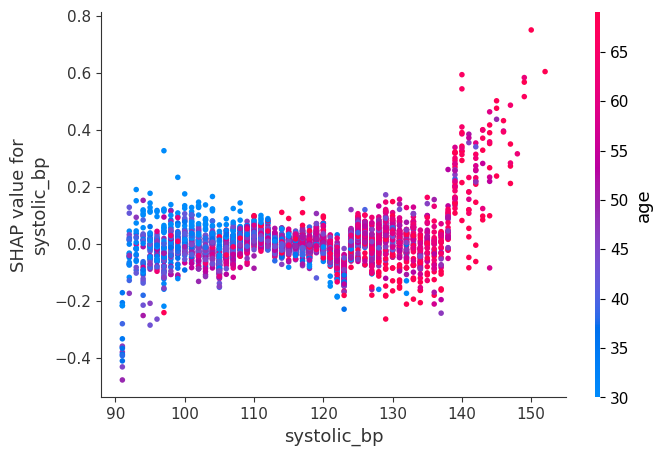

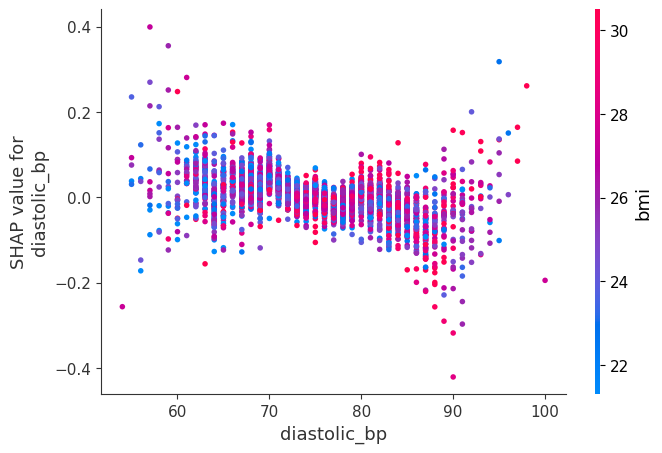

In [ ]:
shap.dependence_plot(
    "systolic_bp",
    shap_values,
    X_shap,
    interaction_index="auto"
)

shap.dependence_plot(
    "diastolic_bp",
    shap_values,
    X_shap,
    interaction_index="auto"
)

# Plot 1: Systolic BP
# Risk is largely flat at normal-to-elevated systolic BP (~95–135), but rises sharply beyond ~140, indicating a clear high-BP threshold effect.
# Higher-age individuals are concentrated at higher SHAP contributions, suggesting that hypertension effects intensify with age.

# Plot 2: Diastolic BP
# Shows a mild negative trend as diastolic BP increases from ~60 to ~90, suggesting higher diastolic values in this range are not strongly risk-increasing in the model.
# At the upper tail (>~90–95), the relationship becomes more scattered with some high-risk outliers, indicating potential interaction / non-linear effects.

# Possibly add hypertension indicator for sys BP > 130 or dias BP > 90, and low dias BP indicator for dias BP < 60 to capture non-linear trend.

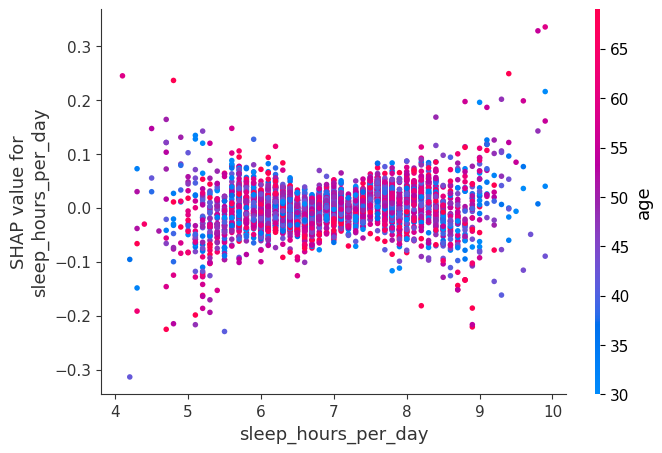

In [ ]:
shap.dependence_plot(
    "sleep_hours_per_day",
    shap_values,
    X_shap,
    interaction_index="age"
)

# The effect of sleep is weak and near-zero around 6–8 hours/day, suggesting minimal contribution to risk in the “normal” sleep range.
# Risk becomes more variable at extreme sleep durations (<~6 or >~8.5 hours), where SHAP values spread out, indicating possible non-linear effect.
# Possibly add indicators for abnormal sleep patterns

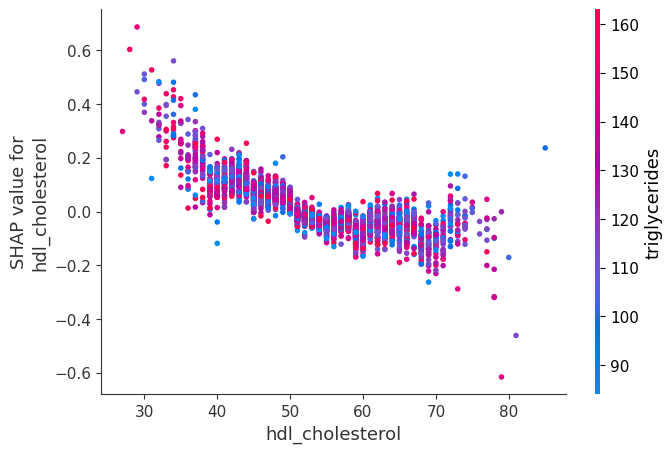

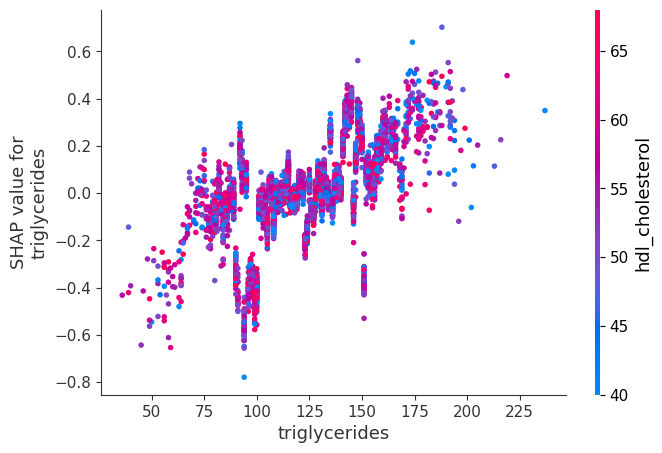

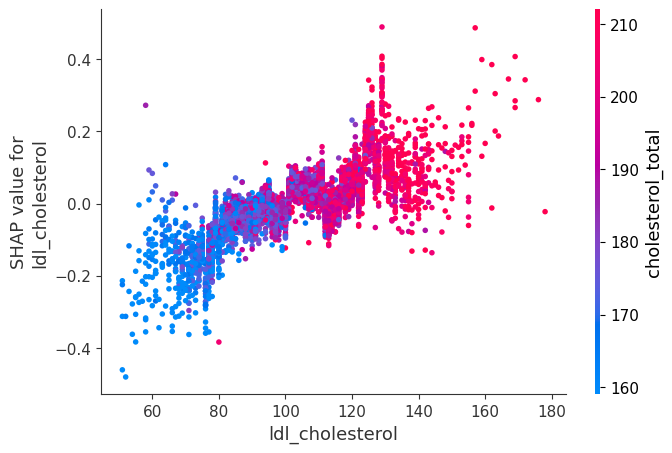

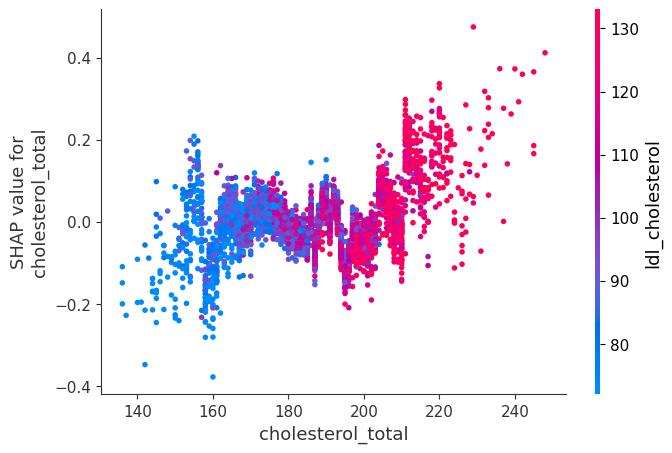

In [ ]:
shap.dependence_plot(
    "hdl_cholesterol",
    shap_values,
    X_shap,
    interaction_index="triglycerides"
)

shap.dependence_plot(
    "triglycerides",
    shap_values,
    X_shap,
    interaction_index="hdl_cholesterol"
)

# (optional: LDL / total cholesterol checks)
shap.dependence_plot(
    "ldl_cholesterol",
    shap_values,
    X_shap,
    interaction_index="auto"
)

shap.dependence_plot(
    "cholesterol_total",
    shap_values,
    X_shap,
    interaction_index="auto"
)

# HDL
# Risk falls sharply as HDL increases from ~30 to ~55, then shows a milder downward slope / plateau at higher HDL levels.
# This suggests HDL is strongly protective at low-to-mid ranges, with diminishing marginal benefit at higher values.

# Triglycerides
# Risk increases steadily with triglycerides, with a clear upward gradient beyond ~150, indicating a stronger adverse effect in the high-triglyceride range.
# Lower HDL (blue) tends to coincide with higher risk contributions, implying lipid interaction effects.

# LDL
# Risk increases non-linearly with LDL, with a sharper rise as LDL moves into the ~110–140+ range.
# Higher total cholesterol values cluster with higher SHAP contributions, reinforcing a joint lipid-risk signal.

# Total cholesterol
# Risk remains near-flat / slightly negative at lower total cholesterol levels (~150–190), but rises sharply beyond ~200–210.
# This indicates a threshold effect where high total cholesterol contributes disproportionately to risk, especially when LDL is also high.

# Possibly add indicators for adnormal levels of each type of cholesterol, and diabetic dyslipidemia indicator which signals diabetes

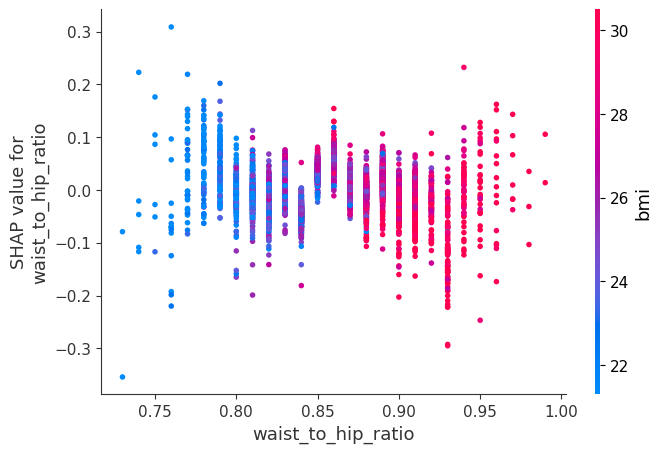

In [ ]:
shap.dependence_plot(
    "waist_to_hip_ratio",
    shap_values,
    X_shap,
    interaction_index="bmi"
)

# Waist-to-hip ratio shows a weak trend with risk, with SHAP values trending upward as ratio approaches ~0.9–1.0.
# Higher BMI points (red) show greater spread and higher SHAP values, suggesting that high BMI is only risky if the individual also has high waist-to-hip ratio. 
# Possibly add central adiposity + BMI interaction.

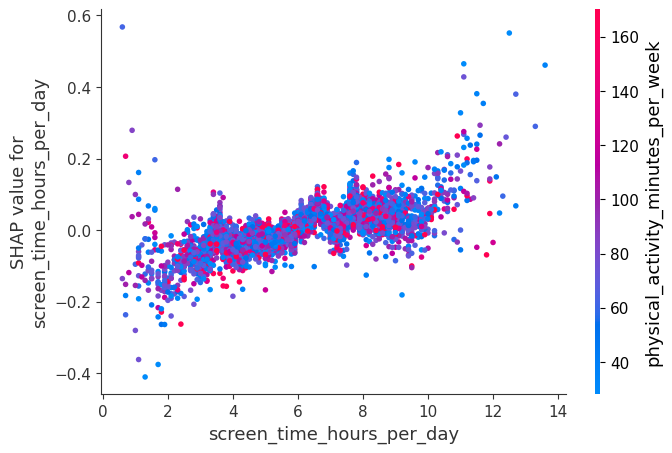

In [ ]:
shap.dependence_plot(
    "screen_time_hours_per_day",
    shap_values,
    X_shap,
    interaction_index="physical_activity_minutes_per_week"
)

# Risk increases gradually with screen time, with a clear upward slope after ~6–8 hours/day, indicating a non-linear lifestyle risk pattern.
# Lower physical activity (blue) appears more common among higher-risk points, suggesting screen time effects may be amplified when activity is low.
# Possible sedentary lifestyle indicator